In [667]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import statsmodels.api as sm
%matplotlib inline 

## Tarefa 1

In [668]:
dados = pd.read_csv(
    "tarefa1.csv"
)  # Corrente(A),Torque(Nm), Incerteza Corrente(A), Incerteza Torque(Nm)
x = dados["Corrente(A)"]
y = dados["Torque(Nm)"]
incx = dados["Incerteza Corrente(A)"]
incy = dados["Incerteza Torque(Nm)"]
dados

,Corrente(A),Torque(Nm),Incerteza Corrente(A),Incerteza Torque(Nm)
0,0.000,0.00,0.040000,0.05
1,0.250,0.21,0.043750,0.05
2,0.511,0.42,0.047665,0.05
3,0.755,0.61,0.051325,0.05
4,1.015,0.74,0.055225,0.05
5,1.252,0.89,0.058780,0.05
6,1.504,1.07,0.062560,0.05
7,1.750,1.25,0.066250,0.05
8,2.009,1.42,0.070135,0.05
9,2.250,1.60,0.073750,0.05


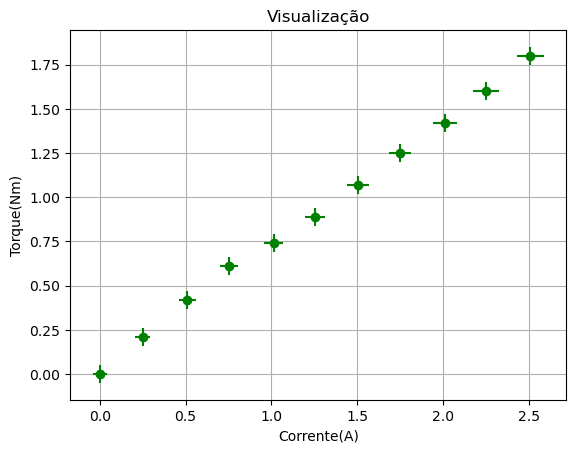

pandas.core.frame.DataFrame

In [669]:
# visualizando os dados pelo gráfico

plt.figure()
plt.errorbar(x, y, incy, incx, "og")
plt.title("Visualização")
plt.xlabel("Corrente(A)")
plt.ylabel("Torque(Nm)")
plt.grid()
plt.show()

type(x.to_frame())

In [670]:
# A função é linear portanto não é precisio linearizar

In [671]:
# ajustando a reta (RLS)
xlin = sm.add_constant(x)
reglin = sm.OLS(y, xlin)
reglin_dat = reglin.fit()
f_de_x = reglin_dat.params
print("coeficiente angular: ", f_de_x.iloc[0])

coeficiente angular:  0.035644504768692076


In [672]:
# transferindo incerteza de z para y
incytransf = np.sqrt(np.power(f_de_x.iloc[1] * incx, 2) + np.power(incy, 2))
incytransf

0     0.057242
1     0.058558
2     0.060023
3     0.061471
4     0.063090
5     0.064630
6     0.066330
7     0.068047
8     0.069911
9     0.071694
10    0.073658
dtype: float64

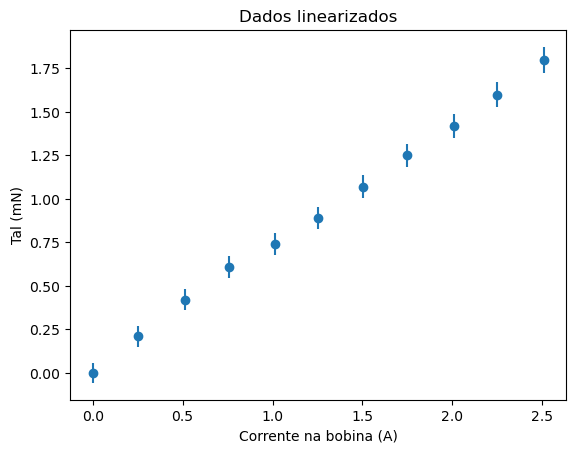

In [673]:
# visualizando os dados linearizados
plt.errorbar(x, y, incytransf, 0, "o")
plt.title("Dados linearizados")
plt.xlabel("Corrente na bobina (A)")
plt.ylabel("Tal (mN)")
plt.show()

In [674]:
# criando os 'pesos' a partir da incerteza
ws = 1 / (incytransf**2)
reglinw = sm.WLS(y, xlin, ws)
result_rlw = reglinw.fit()
fitpars = result_rlw.params
fiterrs = result_rlw.HC0_se
print(fitpars.iloc[0], fitpars.iloc[1])
print(fiterrs.iloc[0], fiterrs.iloc[1])

0.03492180165054182 0.697333305604932
0.016288309433910245 0.00905922430726301


In [675]:
# note que o statsmodels retorna os parâmetros em ordem inversa em relação aos outros dois métodos
p_0 = fitpars.iloc[1]  # coef ang
p_1 = fitpars.iloc[0]  # coef lin
# note que não há raiz quadrada
s_p_0 = fiterrs.iloc[1]  # incert p_0
s_p_1 = fiterrs.iloc[0]  # incert p_1
rp_0 = np.round(p_0, 2)
rp_1 = np.round(p_1, 2)
rs_p_0 = np.round(s_p_0, 2)
rs_p_1 = np.round(s_p_1, 2)
print("coef. angular=", rp_0, "+-", rs_p_0)
print("coef. linear=", rp_1, "+-", rs_p_1)

coef. angular= 0.7 +- 0.01
coef. linear= 0.03 +- 0.02


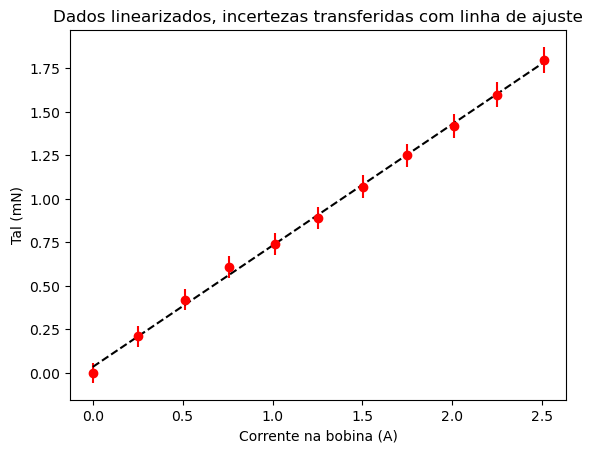

In [676]:
xline = x
yline = fitpars.iloc[0] + fitpars.iloc[1] * x
plt.errorbar(x, y, incytransf, 0, "or")
plt.title("Dados linearizados, incertezas transferidas com linha de ajuste")
plt.xlabel("Corrente na bobina (A)")
plt.ylabel("Tal (mN)")
# incluindo a linha do ajuste linear, k=preto, '--' = linha tracejada
plt.plot(xline, yline, "k--")

In [677]:
# calulando chi^2_red
invpars = fitpars.iloc[1], fitpars.iloc[0]
yhat = np.polyval(invpars, x)
chi_squared = np.sum(((yhat - y) / incytransf) ** 2)
print(chi_squared)
chi2_red = chi_squared / (len(x) - 2)
chi2_red

1.453053757854255


np.float64(0.16145041753936168)

In [678]:
np.round(result_rlw.rsquared, 3)

np.float64(0.998)

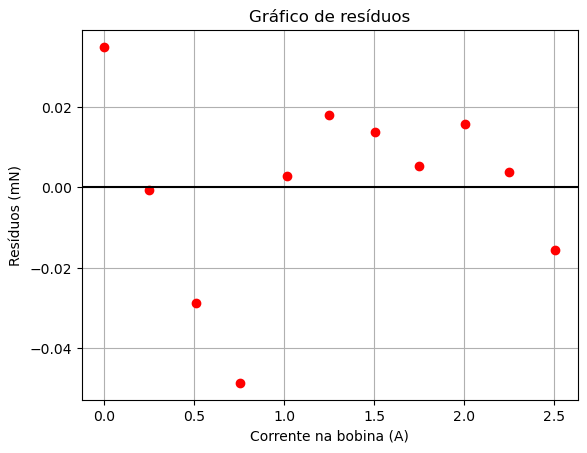

In [679]:
# Grafico de residuos
resid = yhat - y
plt.plot(x, resid, "or")
plt.title("Gráfico de resíduos")
plt.xlabel("Corrente na bobina (A)")
plt.ylabel("Resíduos (mN)")
plt.grid()
plt.axhline(y=0, color="k", linestyle="-")

### Propagando as incertezas obtidas no ajuste

Da teoria para a analise de Torque magnético, temos que o torque é dado por:

<!-- where A
 is the vector of the area of the current ring.
If a current I’ flows in the Helmholtz coils, then, from (1):
T
 = c · I · n A
 I’ · sin  (3)
where  is the angle between B
and the plane vector A
, and
c is a constant of these Helmholtz coils. -->

$$\tau = c \cdot I \cdot n |\vec{A}|I' \cdot sin(\alpha)$$

onde $c$ é uma constante das bobinas de Helmholtz, $I$ é a corrente que passa pela espira, $n$ é o número de espiras, $|\vec{A}|$ é o módulo da área da espira, $I'$ é a corrente que passa pelas bobinas de Helmholtz e $\alpha$ é o ângulo entre o vetor campo magnético e o vetor normal à espira.


In [680]:
# Calculando o momento magnético e sua incerteza
n = 3
diametro_espira = 120 * 10**-3  # m
inc_Diametro_espira = 0.5 * 10**-3
area = np.pi * (diametro_espira / 2) ** 2
inc_area = abs(area * 2 * (inc_Diametro_espira / diametro_espira))
I_espira = 3.009
inc_I_espira = I_espira * 0.015 + 0.04
alpha = 90
inc_alpha = 0.5
seno_alpha = np.sin(np.radians(alpha))
inc_seno_alpha = abs(np.cos(np.radians(alpha)) * np.radians(inc_alpha))

c = p_0 / (n * area * seno_alpha * I_espira)
inc_c = c * np.sqrt(
    (s_p_0 / p_0) ** 2
    + (inc_area / area) ** 2
    + (inc_seno_alpha / seno_alpha) ** 2
    + (inc_I_espira / I_espira) ** 2
)
c, inc_c

C = []
inc_C = []

In [681]:
C.append(c)
inc_C.append(inc_c)

## Tarefa 2

In [682]:
dados = pd.read_csv(
    "tarefa2.csv"
)  # Corrente(A),Torque(Nm), Incerteza Corrente(A), Incerteza Torque(Nm)
x = dados["Número de Espiras"]
y = dados["Torque(Nm)"]
incx = np.zeros(len(x))
incy = dados["Incerteza Torque(Nm)"]
dados

correntes_espiras = dados["Corrente Espira(A)"]
inc_correntes_espiras = dados["Incerteza Corrente Espira(A)"]
correntes_bobina = dados["Corrente Bobina(A)"]
inc_correntes_bobina = dados["Incerteza Corrente Bobina(A)"]

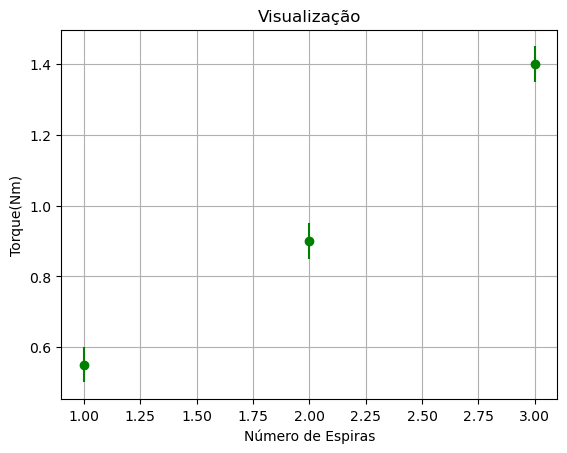

pandas.core.frame.DataFrame

In [683]:
# visualizando os dados pelo gráfico

plt.figure()
plt.errorbar(x, y, incy, incx, "og")
plt.title("Visualização")
plt.xlabel("Número de Espiras")
plt.ylabel("Torque(Nm)")
plt.grid()
plt.show()

type(x.to_frame())

In [684]:
# A função é linear portanto não é precisio linearizar

In [685]:
# ajustando a reta (RLS)
xlin = sm.add_constant(x)
reglin = sm.OLS(y, xlin)
reglin_dat = reglin.fit()
f_de_x = reglin_dat.params
print("coeficiente angular: ", f_de_x.iloc[0])

coeficiente angular:  0.10000000000000042


In [686]:
# transferindo incerteza de z para y
incytransf = np.sqrt(np.power(f_de_x.iloc[1] * incx, 2) + np.power(incy, 2))
incytransf

0    0.05
1    0.05
2    0.05
Name: Incerteza Torque(Nm), dtype: float64

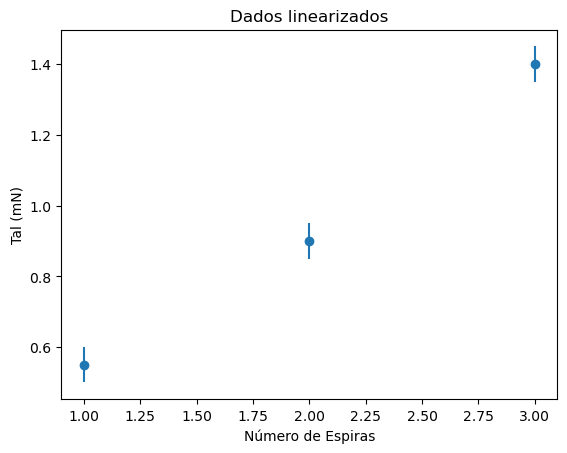

In [687]:
# visualizando os dados linearizados
plt.errorbar(x, y, incytransf, 0, "o")
plt.title("Dados linearizados")
plt.xlabel("Número de Espiras")
plt.ylabel("Tal (mN)")
plt.show()

In [688]:
# criando os 'pesos' a partir da incerteza
ws = 1 / (incytransf**2)
reglinw = sm.WLS(y, xlin, ws)
result_rlw = reglinw.fit()
fitpars = result_rlw.params
fiterrs = result_rlw.HC0_se
print(fitpars.iloc[0], fitpars.iloc[1])
print(fiterrs.iloc[0], fiterrs.iloc[1])

0.09999999999999964 0.4250000000000001
0.04082482904638662 0.017677669529663795


In [689]:
# note que o statsmodels retorna os parâmetros em ordem inversa em relação aos outros dois métodos
p_0 = fitpars.iloc[1]  # coef ang
p_1 = fitpars.iloc[0]  # coef lin
# note que não há raiz quadrada
s_p_0 = fiterrs.iloc[1]  # incert p_0
s_p_1 = fiterrs.iloc[0]  # incert p_1
rp_0 = np.round(p_0, 2)
rp_1 = np.round(p_1, 2)
rs_p_0 = np.round(s_p_0, 2)
rs_p_1 = np.round(s_p_1, 2)
print("coef. angular=", rp_0, "+-", rs_p_0)
print("coef. linear=", rp_1, "+-", rs_p_1)

coef. angular= 0.43 +- 0.02
coef. linear= 0.1 +- 0.04


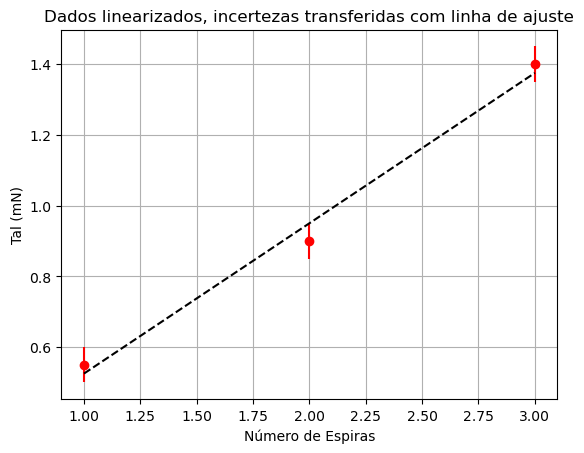

In [690]:
xline = x
yline = fitpars.iloc[0] + fitpars.iloc[1] * x
plt.errorbar(x, y, incytransf, 0, "or")
plt.title("Dados linearizados, incertezas transferidas com linha de ajuste")
plt.xlabel("Número de Espiras")
plt.ylabel("Tal (mN)")
plt.grid()
# incluindo a linha do ajuste linear, k=preto, '--' = linha tracejada
plt.plot(xline, yline, "k--")

In [691]:
# calulando chi^2_red
invpars = fitpars.iloc[1], fitpars.iloc[0]
yhat = np.polyval(invpars, x)
chi_squared = np.sum(((yhat - y) / incytransf) ** 2)
print(chi_squared)
chi2_red = chi_squared / (len(x) - 2)
chi2_red

1.4999999999999982


np.float64(1.4999999999999982)

In [692]:
np.round(result_rlw.rsquared, 3)

np.float64(0.99)

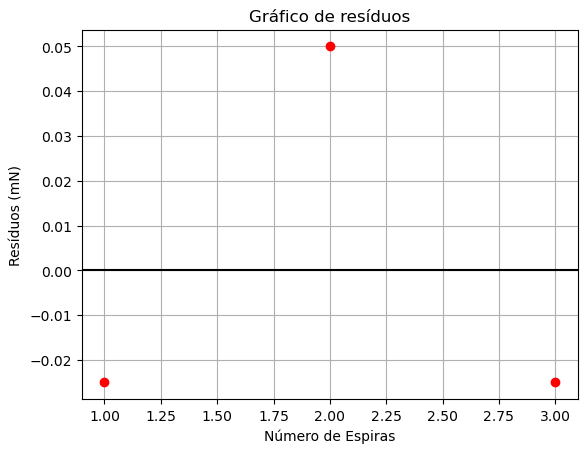

In [693]:
# Grafico de residuos
resid = yhat - y
plt.plot(x, resid, "or")
plt.title("Gráfico de resíduos")
plt.xlabel("Número de Espiras")
plt.ylabel("Resíduos (mN)")
plt.grid()
plt.axhline(y=0, color="k", linestyle="-")

### Propagando as incertezas obtidas no ajuste

Da teoria para a analise de Torque magnético, temos que o torque é dado por:

<!-- where A
 is the vector of the area of the current ring.
If a current I’ flows in the Helmholtz coils, then, from (1):
T
 = c · I · n A
 I’ · sin  (3)
where  is the angle between B
and the plane vector A
, and
c is a constant of these Helmholtz coils. -->

$$\tau = c \cdot I \cdot n |\vec{A}|I' \cdot sin(\alpha)$$

onde $c$ é uma constante das bobinas de Helmholtz, $I$ é a corrente que passa pela espira, $n$ é o número de espiras, $|\vec{A}|$ é o módulo da área da espira, $I'$ é a corrente que passa pelas bobinas de Helmholtz e $\alpha$ é o ângulo entre o vetor campo magnético e o vetor normal à espira.


In [694]:
# Calculando o momento magnético e sua incerteza

diametro_espira = 120 * 10**-3  # m
inc_Diametro_espira = 0.5 * 10**-3
area = np.pi * (diametro_espira / 2) ** 2
inc_area = abs(area * 2 * (inc_Diametro_espira / diametro_espira))
alpha = 90
inc_alpha = 0.5
seno_alpha = np.sin(np.radians(alpha))
inc_seno_alpha = abs(np.cos(np.radians(alpha)) * np.radians(inc_alpha))

I_espira = np.mean(correntes_espiras)
inc_I_espira = np.sqrt(np.sum(inc_correntes_espiras**2)) / len(inc_correntes_espiras)

I_bobina = np.mean(correntes_bobina)
inc_I_bobina = np.sqrt(np.sum(inc_correntes_bobina**2)) / len(inc_correntes_bobina)

c = p_0 / (I_espira * I_bobina * area * seno_alpha)
inc_c = c * np.sqrt(
    (s_p_0 / p_0) ** 2
    + (inc_I_espira / I_espira) ** 2
    + (inc_I_bobina / I_bobina) ** 2
    + (inc_area / area) ** 2
    + (inc_seno_alpha / seno_alpha) ** 2
)

c, inc_c

(np.float64(6.2198413730566235), np.float64(0.3093522407214407))

In [695]:
C.append(c)
inc_C.append(inc_c)

## Tarefa 3

In [696]:
dados = pd.read_csv(
    "tarefa3.csv"
)  # Corrente(A),Torque(Nm), Incerteza Corrente(A), Incerteza Torque(Nm)
x = dados["Angulo(degree)"]
y = dados["Torque(Nm)"]
incx = dados["Incerteza Angulo(degree)"]
incy = dados["Incerteza Torque(Nm)"]
dados

,Angulo(degree),Torque(Nm),Incerteza Angulo(degree),Incerteza Torque(Nm)
0,-60,-1.25,0.5,0.05
1,-30,-0.68,0.5,0.05
2,0,0.00,0.5,0.05
3,30,0.78,0.5,0.05
4,60,1.31,0.5,0.05
5,90,1.49,0.5,0.05


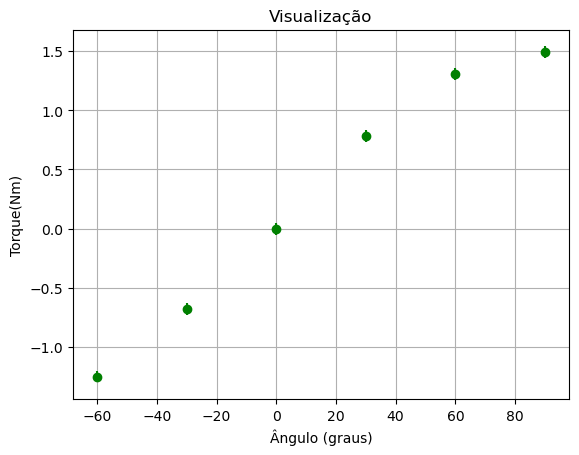

pandas.core.frame.DataFrame

In [697]:
# visualizando os dados pelo gráfico

plt.figure()
plt.errorbar(x, y, incy, incx, "og")
plt.title("Visualização")
plt.xlabel("Ângulo (graus)")
plt.ylabel("Torque(Nm)")
plt.grid()
plt.show()

type(x.to_frame())

In [698]:
# linearizando a função usando seno
z = np.sin(np.radians(x))
incz = abs(np.cos(np.radians(x)) * np.radians(incx))

z, incz

(0   -0.866025
 1   -0.500000
 2    0.000000
 3    0.500000
 4    0.866025
 5    1.000000
 Name: Angulo(degree), dtype: float64,
 0    4.363323e-03
 1    7.557497e-03
 2    8.726646e-03
 3    7.557497e-03
 4    4.363323e-03
 5    5.343530e-19
 dtype: float64)

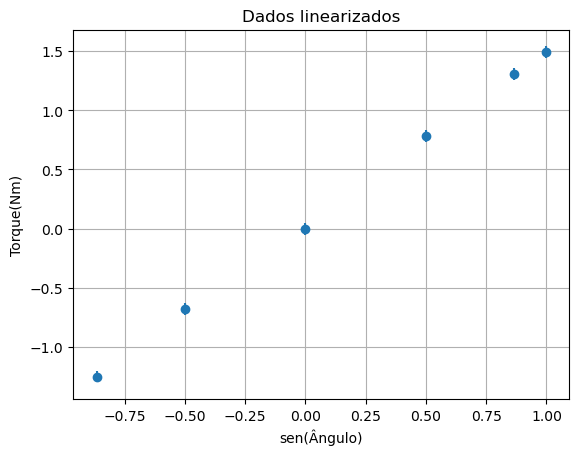

In [699]:
# visualizando os dados linearizados
plt.errorbar(z, y, incy,incz,'o')
plt.title("Dados linearizados")
plt.xlabel("sen(Ângulo)")
plt.ylabel("Torque(Nm)")
plt.grid()
plt.show()

In [700]:
# ajustando a reta (RLS)
xlin = sm.add_constant(z)
reglin = sm.OLS(y, xlin)
reglin_dat = reglin.fit()
f_de_z = reglin_dat.params
print("coeficiente angular: ", f_de_z.iloc[0])

coeficiente angular:  0.03017499801834328


In [701]:
# transferindo incerteza de z para y
incytransf = np.sqrt(np.power(f_de_z.iloc[1] * incz, 2) + np.power(incy, 2))
incytransf

0    0.050409
1    0.051218
2    0.051617
3    0.051218
4    0.050409
5    0.050000
dtype: float64

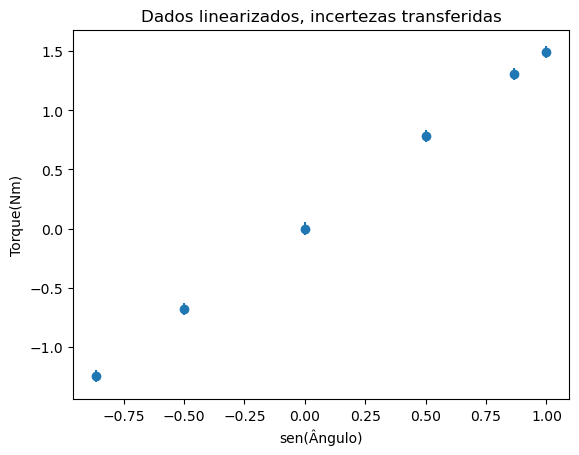

In [702]:
# visualizando os dados linearizados
plt.errorbar(z, y, incytransf, 0, "o")
plt.title("Dados linearizados, incertezas transferidas")
plt.xlabel("sen(Ângulo)")
plt.ylabel("Torque(Nm)")
plt.show()

In [703]:
# criando os 'pesos' a partir da incerteza
ws = 1 / (incytransf**2)
reglinw = sm.WLS(y, xlin, ws)
result_rlw = reglinw.fit()
fitpars = result_rlw.params
fiterrs = result_rlw.HC0_se
print(fitpars.iloc[0], fitpars.iloc[1])
print(fiterrs.iloc[0], fiterrs.iloc[1])

0.030176309703196597 1.4689463066109631
0.00786248468173505 0.007551133858699546


In [704]:
# note que o statsmodels retorna os parâmetros em ordem inversa em relação aos outros dois métodos
p_0 = fitpars.iloc[1]  # coef ang
p_1 = fitpars.iloc[0]  # coef lin
# note que não há raiz quadrada
s_p_0 = fiterrs.iloc[1]  # incert p_0
s_p_1 = fiterrs.iloc[0]  # incert p_1
rp_0 = np.round(p_0, 2)
rp_1 = np.round(p_1, 2)
rs_p_0 = np.round(s_p_0, 2)
rs_p_1 = np.round(s_p_1, 2)
print("coef. angular=", rp_0, "+-", rs_p_0)
print("coef. linear=", rp_1, "+-", rs_p_1)

coef. angular= 1.47 +- 0.01
coef. linear= 0.03 +- 0.01


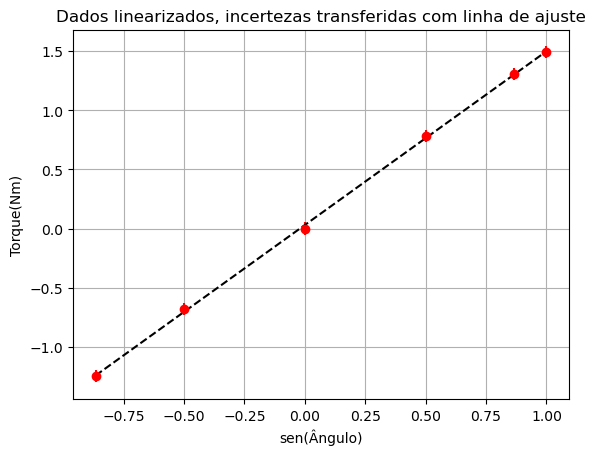

In [705]:
xline = z
yline = fitpars.iloc[0] + fitpars.iloc[1] * z
plt.errorbar(z, y, incytransf, 0, "or")
plt.title("Dados linearizados, incertezas transferidas com linha de ajuste")
plt.xlabel("sen(Ângulo)")
plt.ylabel("Torque(Nm)")
plt.grid()
# incluindo a linha do ajuste linear, k=preto, '--' = linha tracejada
plt.plot(xline, yline, "k--")

In [706]:
# calulando chi^2_red
invpars = fitpars.iloc[1], fitpars.iloc[0]
yhat = np.polyval(invpars, z)
chi_squared = np.sum(((yhat - y) / incytransf) ** 2)
print(chi_squared)
chi2_red = chi_squared / (len(z) - 2)
chi2_red

0.7385247227803645


np.float64(0.18463118069509113)

In [707]:
np.round(result_rlw.rsquared, 3)

np.float64(1.0)

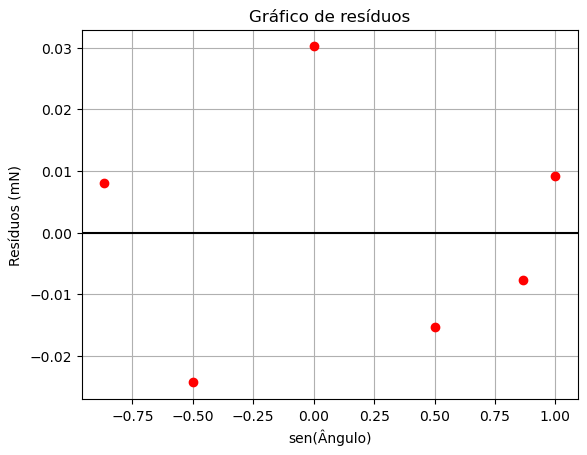

In [708]:
# Grafico de residuos
resid = yhat - y
plt.plot(z, resid, "or")
plt.title("Gráfico de resíduos")
plt.xlabel("sen(Ângulo)")
plt.ylabel("Resíduos (mN)")
plt.grid()
plt.axhline(y=0, color="k", linestyle="-")

### Propagando as incertezas obtidas no ajuste

Da teoria para a analise de Torque magnético, temos que o torque é dado por:

<!-- where A
 is the vector of the area of the current ring.
If a current I’ flows in the Helmholtz coils, then, from (1):
T
 = c · I · n A
 I’ · sin  (3)
where  is the angle between B
and the plane vector A
, and
c is a constant of these Helmholtz coils. -->

$$\tau = c \cdot I \cdot n |\vec{A}|I' \cdot sin(\alpha)$$

onde $c$ é uma constante das bobinas de Helmholtz, $I$ é a corrente que passa pela espira, $n$ é o número de espiras, $|\vec{A}|$ é o módulo da área da espira, $I'$ é a corrente que passa pelas bobinas de Helmholtz e $\alpha$ é o ângulo entre o vetor campo magnético e o vetor normal à espira.


In [709]:
# Calculando o momento magnético e sua incerteza
n = 3
diametro_espira = 120 * 10**-3  # m
inc_Diametro_espira = 0.5 * 10**-3
area = np.pi * (diametro_espira / 2) ** 2
inc_area = abs(area * 2 * (inc_Diametro_espira / diametro_espira))
I_espira = 3.005
inc_I_espira = I_espira * 0.015 + 0.04
I_bobina = 2.004
inc_I_bobina = I_bobina * 0.015 + 0.04

c = p_0 / (n * area * I_bobina * I_espira)
inc_c = c * np.sqrt(
    (s_p_0 / p_0) ** 2
    + (inc_area / area) ** 2
    + (inc_I_bobina / I_bobina) ** 2
    + (inc_I_espira / I_espira) ** 2
)
c, inc_c

(np.float64(7.189357829411667), np.float64(0.33099147439964777))

In [710]:
C.append(c)
inc_C.append(inc_c)

## Tarefa 4

In [711]:
dados = pd.read_csv(
    "tarefa4.csv"
) 
x = dados["Diametro(mm)"] * 10**-3
y = dados["Torque(Nm)"]
incx = dados["Incerteza Diametro(mm)"] * 10**-3
incy = dados["Incerteza Torque(Nm)"]
dados

,Diametro(mm),Torque(Nm),Incerteza Diametro(mm),Incerteza Torque(Nm)
0,60,0.22,0.5,0.05
1,85,0.29,0.5,0.05
2,120,0.48,0.5,0.05


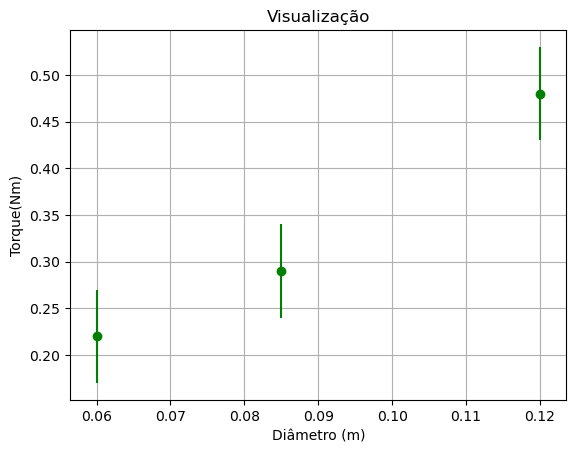

pandas.core.frame.DataFrame

In [712]:
# visualizando os dados pelo gráfico

plt.figure()
plt.errorbar(x, y, incy, incx, "og")
plt.title("Visualização")
plt.xlabel("Diâmetro (m)")
plt.ylabel("Torque(Nm)")
plt.grid()
plt.show()

type(x.to_frame())

In [713]:
# A função de area tem dependencia quadrática com o diâmetro
z = np.pi * (x / 2) ** 2
incz = abs(z * 2 * (incx / x))
z, incz

(0    0.002827
 1    0.005675
 2    0.011310
 Name: Diametro(mm), dtype: float64,
 0    0.000047
 1    0.000067
 2    0.000094
 dtype: float64)

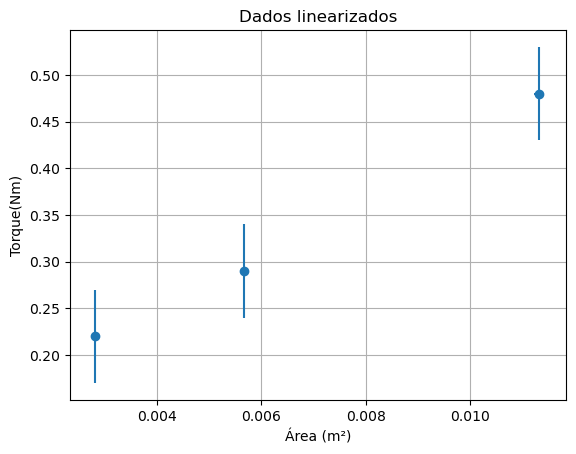

In [714]:
# visualizando os dados linearizados
plt.errorbar(z, y, incy,incz,'o')
plt.title("Dados linearizados")
plt.xlabel("Área (m²)")
plt.ylabel("Torque(Nm)")
plt.grid()
plt.show()

In [715]:
# ajustando a reta (RLS)
xlin = sm.add_constant(z)
reglin = sm.OLS(y, xlin)
reglin_dat = reglin.fit()
f_de_z = reglin_dat.params
print("coeficiente angular: ", f_de_z.iloc[0])

coeficiente angular:  0.12473343033880657


In [716]:
# transferindo incerteza de z para y
incytransf = np.sqrt(np.power(f_de_z.iloc[1] * incz, 2) + np.power(incy, 2))
incytransf

0    0.050021
1    0.050043
2    0.050086
dtype: float64

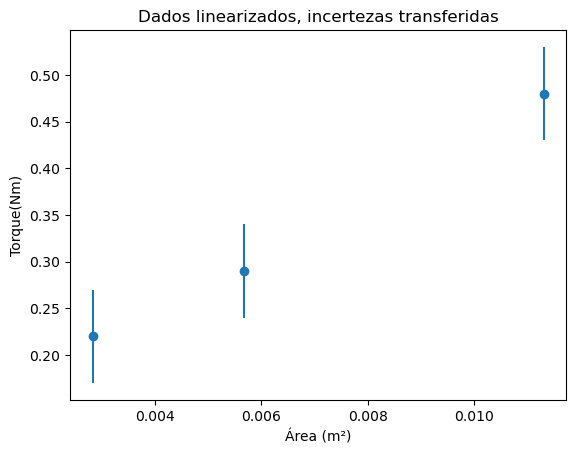

In [717]:
# visualizando os dados linearizados
plt.errorbar(z, y, incytransf, 0, "o")
plt.title("Dados linearizados, incertezas transferidas")
plt.xlabel("Área (m²)")
plt.ylabel("Torque(Nm)")
plt.show()

In [718]:
# criando os 'pesos' a partir da incerteza
ws = 1 / (incytransf**2)
reglinw = sm.WLS(y, xlin, ws)
result_rlw = reglinw.fit()
fitpars = result_rlw.params
fiterrs = result_rlw.HC0_se
print(fitpars.iloc[0], fitpars.iloc[1])
print(fiterrs.iloc[0], fiterrs.iloc[1])

0.12474300306505243 31.08122798784846
0.009422722004312083 0.9263373252113573


In [719]:
# note que o statsmodels retorna os parâmetros em ordem inversa em relação aos outros dois métodos
p_0 = fitpars.iloc[1]  # coef ang
p_1 = fitpars.iloc[0]  # coef lin
# note que não há raiz quadrada
s_p_0 = fiterrs.iloc[1]  # incert p_0
s_p_1 = fiterrs.iloc[0]  # incert p_1
rp_0 = np.round(p_0, 2)
rp_1 = np.round(p_1, 2)
rs_p_0 = np.round(s_p_0, 2)
rs_p_1 = np.round(s_p_1, 2)
print("coef. angular=", rp_0, "+-", rs_p_0)
print("coef. linear=", rp_1, "+-", rs_p_1)

coef. angular= 31.08 +- 0.93
coef. linear= 0.12 +- 0.01


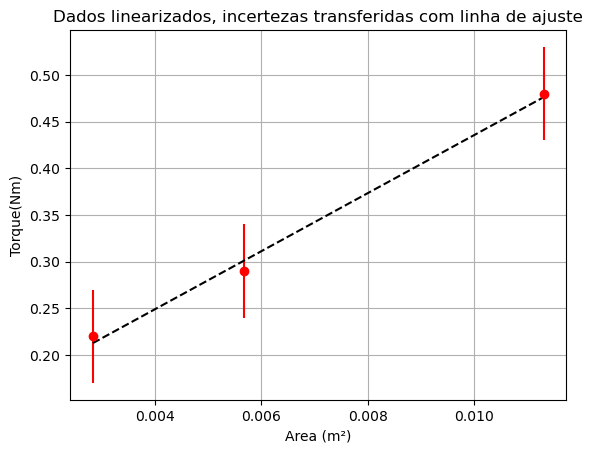

In [720]:
xline = z
yline = fitpars.iloc[0] + fitpars.iloc[1] * z
plt.errorbar(z, y, incytransf, 0, "or")
plt.title("Dados linearizados, incertezas transferidas com linha de ajuste")
plt.xlabel("Area (m²)")
plt.ylabel("Torque(Nm)")
plt.grid()
# incluindo a linha do ajuste linear, k=preto, '--' = linha tracejada
plt.plot(xline, yline, "k--")

In [721]:
# calulando chi^2_red
invpars = fitpars.iloc[1], fitpars.iloc[0]
yhat = np.polyval(invpars, z)
chi_squared = np.sum(((yhat - y) / incytransf) ** 2)
print(chi_squared)
chi2_red = chi_squared / (len(z) - 2)
chi2_red

0.07663338170154413


np.float64(0.07663338170154413)

In [722]:
np.round(result_rlw.rsquared, 3)

np.float64(0.995)

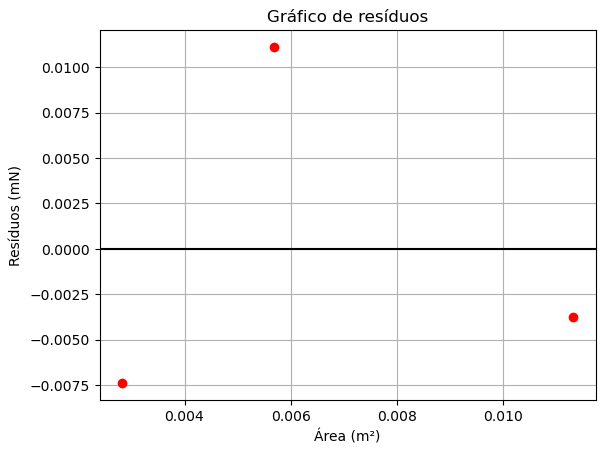

In [723]:
# Grafico de residuos
resid = yhat - y
plt.plot(z, resid, "or")
plt.title("Gráfico de resíduos")
plt.xlabel("Área (m²)")
plt.ylabel("Resíduos (mN)")
plt.grid()
plt.axhline(y=0, color="k", linestyle="-")

### Propagando as incertezas obtidas no ajuste

Da teoria para a analise de Torque magnético, temos que o torque é dado por:

<!-- where A
 is the vector of the area of the current ring.
If a current I’ flows in the Helmholtz coils, then, from (1):
T
 = c · I · n A
 I’ · sin  (3)
where  is the angle between B
and the plane vector A
, and
c is a constant of these Helmholtz coils. -->

$$\tau = c \cdot I \cdot n |\vec{A}|I' \cdot sin(\alpha)$$

onde $c$ é uma constante das bobinas de Helmholtz, $I$ é a corrente que passa pela espira, $n$ é o número de espiras, $|\vec{A}|$ é o módulo da área da espira, $I'$ é a corrente que passa pelas bobinas de Helmholtz e $\alpha$ é o ângulo entre o vetor campo magnético e o vetor normal à espira.


In [724]:
# Calculando o momento magnético e sua incerteza
n = 3

I_espira = 3.008
inc_I_espira = I_espira * 0.015 + 0.04
I_bobina = 2.02
inc_I_bobina = I_bobina * 0.015 + 0.04

alpha = 90
inc_alpha = 0.5
seno_alpha = np.sin(np.radians(alpha))
inc_seno_alpha = abs(np.cos(np.radians(alpha)) * np.radians(inc_alpha))

c = p_0 / (n * I_bobina * I_espira * seno_alpha)
inc_c = c * np.sqrt(
    (s_p_0 / p_0) ** 2
    + (inc_I_bobina / I_bobina) ** 2
    + (inc_I_espira / I_espira) ** 2
    + (inc_seno_alpha / seno_alpha) ** 2
)

c, inc_c

(np.float64(1.7050915922692653), np.float64(0.09182533679087963))

In [725]:
C.append(c)
inc_C.append(inc_c)

## Tarefa 5

In [726]:
dados = pd.read_csv(
    "tarefa5.csv"
)  # Corrente(A),Torque(Nm), Incerteza Corrente(A), Incerteza Torque(Nm)
x = dados["Corrente(A)"]
y = dados["Torque(Nm)"]
incx = dados["Incerteza Corrente(A)"]
incy = dados["Incerteza Torque(Nm)"]
dados

,Corrente(A),Torque(Nm),Incerteza Corrente(A),Incerteza Torque(Nm)
0,0.000,0.00,0.040000,0.05
1,0.502,0.30,0.047530,0.05
2,1.005,0.49,0.055075,0.05
3,1.502,0.67,0.062530,0.05
4,1.999,0.92,0.069985,0.05
5,2.502,1.13,0.077530,0.05
6,3.004,1.46,0.085060,0.05
7,3.507,1.62,0.092605,0.05
8,3.997,1.90,0.099955,0.05
9,4.500,2.16,0.107500,0.05


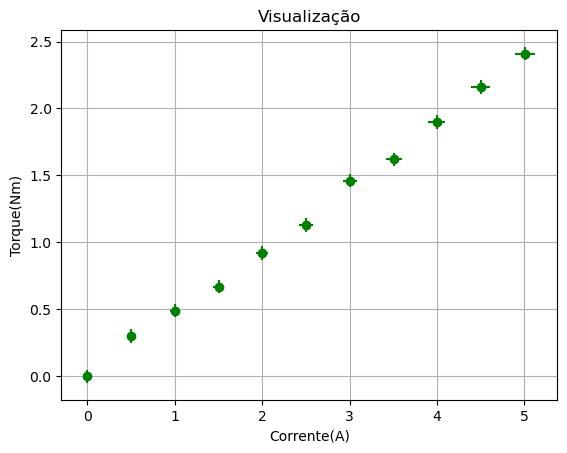

pandas.core.frame.DataFrame

In [727]:
# visualizando os dados pelo gráfico

plt.figure()
plt.errorbar(x, y, incy, incx, "og")
plt.title("Visualização")
plt.xlabel("Corrente(A)")
plt.ylabel("Torque(Nm)")
plt.grid()
plt.show()

type(x.to_frame())

In [728]:
# A função é linear portanto não é precisio linearizar

In [729]:
# ajustando a reta (RLS)
xlin = sm.add_constant(x)
reglin = sm.OLS(y, xlin)
reglin_dat = reglin.fit()
f_de_x = reglin_dat.params
print("coeficiente angular: ", f_de_x.iloc[0])

coeficiente angular:  -0.002640359755602062


In [730]:
# transferindo incerteza de z para y
incytransf = np.sqrt(np.power(f_de_x.iloc[1] * incx, 2) + np.power(incy, 2))
incytransf

0     0.053496
1     0.054872
2     0.056445
3     0.058175
4     0.060064
5     0.062124
6     0.064314
7     0.066630
8     0.068990
9     0.071510
10    0.074128
dtype: float64

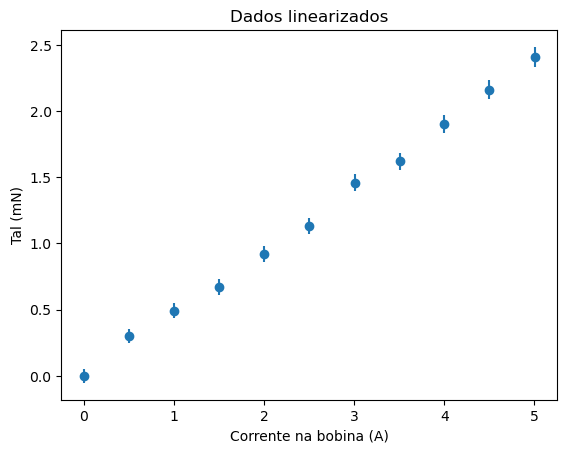

In [731]:
# visualizando os dados linearizados
plt.errorbar(x, y, incytransf, 0, "o")
plt.title("Dados linearizados")
plt.xlabel("Corrente na bobina (A)")
plt.ylabel("Tal (mN)")
plt.show()

In [732]:
# criando os 'pesos' a partir da incerteza
ws = 1 / (incytransf**2)
reglinw = sm.WLS(y, xlin, ws)
result_rlw = reglinw.fit()
fitpars = result_rlw.params
fiterrs = result_rlw.HC0_se
print(fitpars.iloc[0], fitpars.iloc[1])
print(fiterrs.iloc[0], fiterrs.iloc[1])

0.0029453076747623097 0.4730983217338994
0.019995075944138085 0.006437246933506047


In [733]:
# note que o statsmodels retorna os parâmetros em ordem inversa em relação aos outros dois métodos
p_0 = fitpars.iloc[1]  # coef ang
p_1 = fitpars.iloc[0]  # coef lin
# note que não há raiz quadrada
s_p_0 = fiterrs.iloc[1]  # incert p_0
s_p_1 = fiterrs.iloc[0]  # incert p_1
rp_0 = np.round(p_0, 2)
rp_1 = np.round(p_1, 2)
rs_p_0 = np.round(s_p_0, 2)
rs_p_1 = np.round(s_p_1, 2)
print("coef. angular=", rp_0, "+-", rs_p_0)
print("coef. linear=", rp_1, "+-", rs_p_1)

coef. angular= 0.47 +- 0.01
coef. linear= 0.0 +- 0.02


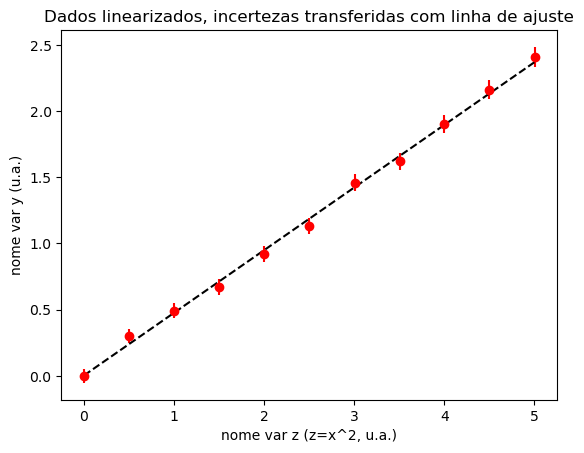

In [734]:
xline = x
yline = fitpars.iloc[0] + fitpars.iloc[1] * x
plt.errorbar(x, y, incytransf, 0, "or")
plt.title("Dados linearizados, incertezas transferidas com linha de ajuste")
plt.xlabel("nome var z (z=x^2, u.a.)")
plt.ylabel("nome var y (u.a.)")
# incluindo a linha do ajuste linear, k=preto, '--' = linha tracejada
plt.plot(xline, yline, "k--")

In [735]:
# calulando chi^2_red
invpars = fitpars.iloc[1], fitpars.iloc[0]
yhat = np.polyval(invpars, x)
chi_squared = np.sum(((yhat - y) / incytransf) ** 2)
print(chi_squared)
chi2_red = chi_squared / (len(x) - 2)
chi2_red

3.9946418302388693


np.float64(0.44384909224876323)

In [736]:
np.round(result_rlw.rsquared, 3)

np.float64(0.997)

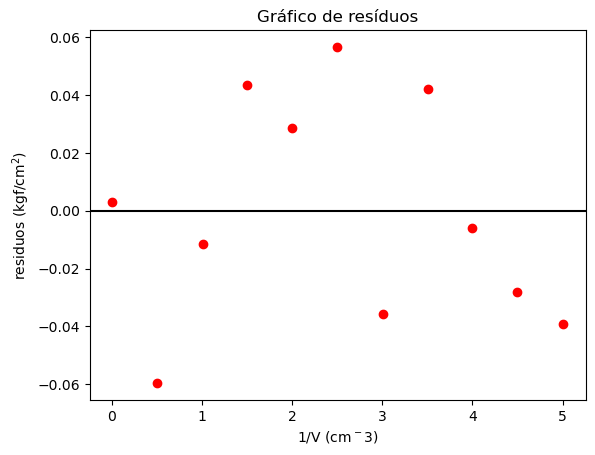

In [737]:
# Grafico de residuos
resid = yhat - y
plt.plot(x, resid, "or")
plt.title("Gráfico de resíduos")
plt.xlabel("1/V (cm$^-3$)")
plt.ylabel("residuos (kgf/cm$^2$)")
plt.axhline(y=0, color="k", linestyle="-")

### Propagando as incertezas obtidas no ajuste

Da teoria para a analise de Torque magnético, temos que o torque é dado por:

<!-- where A
 is the vector of the area of the current ring.
If a current I’ flows in the Helmholtz coils, then, from (1):
T
 = c · I · n A
 I’ · sin  (3)
where  is the angle between B
and the plane vector A
, and
c is a constant of these Helmholtz coils. -->

$$\tau = c \cdot I \cdot n |\vec{A}|I' \cdot sin(\alpha)$$

onde $c$ é uma constante das bobinas de Helmholtz, $I$ é a corrente que passa pela espira, $n$ é o número de espiras, $|\vec{A}|$ é o módulo da área da espira, $I'$ é a corrente que passa pelas bobinas de Helmholtz e $\alpha$ é o ângulo entre o vetor campo magnético e o vetor normal à espira.


In [738]:
# Calculando o momento magnético e sua incerteza
n = 3
diametro_espira = 120 * 10**-3  # m
inc_Diametro_espira = 0.5 * 10**-3
area = np.pi * (diametro_espira / 2) ** 2
inc_area = abs(area * 2 * (inc_Diametro_espira / diametro_espira))
I_bobina = 2.01
inc_I_bobina = I_bobina * 0.015 + 0.04
alpha = 90
inc_alpha = 0.5
seno_alpha = np.sin(np.radians(alpha))
inc_seno_alpha = abs(np.cos(np.radians(alpha)) * np.radians(inc_alpha))

c = p_0 / (n * area * seno_alpha * I_bobina)
inc_c = c * np.sqrt(
    (s_p_0 / p_0) ** 2
    + (inc_area / area) ** 2
    + (inc_seno_alpha / seno_alpha) ** 2
    + (inc_I_bobina / I_bobina) ** 2
)
c, inc_c

(np.float64(6.937160168825313), np.float64(0.26621238076476345))

In [739]:
C.append(c)
inc_C.append(inc_c)

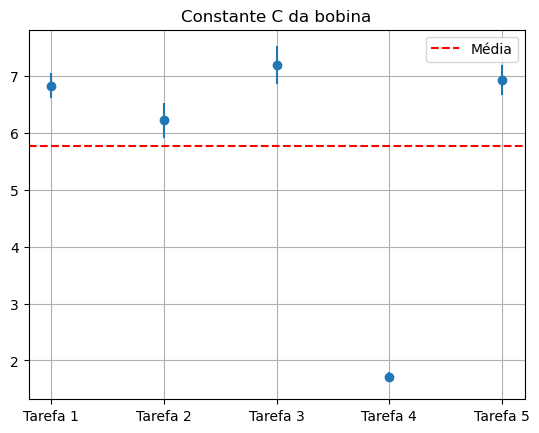

In [740]:
# Plot valores de C e suas incertezas
tarefas = ["Tarefa 1", "Tarefa 2", "Tarefa 3", "Tarefa 4", "Tarefa 5"]
plt.errorbar(tarefas, C, inc_C, fmt="o")
plt.axhline(y=np.mean(C), color='r', linestyle='--', label='Média')
plt.title("Constante C da bobina")
plt.legend()
plt.grid()
plt.show()

